In [45]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели
import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# !conda install -c conda-forge lightgbm
from lightgbm import LGBMRegressor


# 4. Метирки качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image


# Python 2 and 3 compatibility
# pip install future
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# будем отображать графики прямо в jupyter'e
%pylab inline
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10,7

# Построение графика
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

Populating the interactive namespace from numpy and matplotlib


In [50]:
train = pd.read_csv('Kurs_project_task/train.csv')
test = pd.read_csv('Kurs_project_task/test.csv')

y_train = train['Price']
train.drop('Price', axis=1, inplace=True)

train['is_test'] = 0
test['is_test'] = 1

# Соединяю
df = pd.concat([train, test])

df = pd.get_dummies(df)

df.loc[df['Floor'] == 78, 'Floor'] = 8
df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = 2011
df.loc[df['HouseFloor'] == 117, 'HouseFloor'] = 17


# Разделяю
train = df[df.is_test==0].drop('is_test', axis=1)
test = df[df.is_test==1].drop('is_test', axis=1)

train.loc[train['Floor'] > train['HouseFloor'], 'Floor'] = train['HouseFloor']
test.loc[test['Floor'] > test['HouseFloor'], 'Floor'] = test['HouseFloor']

train.loc[train['LifeSquare'] > train['Square'], 'Square'] = train['LifeSquare']
test.loc[test['LifeSquare'] > test['Square'], 'Square'] = test['LifeSquare']

train['LifeSquare']=train['LifeSquare'].fillna(train.groupby('Rooms')['LifeSquare'].transform('mean'))
test['LifeSquare']=test['LifeSquare'].fillna(test.groupby('Rooms')['LifeSquare'].transform('mean'))
train.drop('Healthcare_1', axis=1, inplace=True)
test.drop('Healthcare_1', axis=1, inplace=True)

#
# Рассчет моделей
#

X_final = pd.read_csv('Kurs_project_task/test.csv')
X_final = pd.get_dummies(X_final)

preds_final = pd.DataFrame()
preds_final['Id'] = test['Id'].copy()

parameters = [{'n_estimators': np.arange(50, 500, 50),
               'max_features': np.arange(3, 10, 2),
               'max_depth': np.arange(4, 20, 4),
               'min_samples_leaf':np.arange(10, 11),
               }]

rfc_ls = GridSearchCV(
    estimator=RandomForestRegressor(random_state=100), 
    param_grid=parameters,
    cv=5)

rfc_ls.fit(train, y)

model = rfc_ls.best_estimator_
model.fit(train, y)

y_pred_final = model.predict(test)

preds_final['Price'] = y_pred_final
time_now = datetime.datetime.now()
preds_final.to_csv(time_now.strftime("%d:%m:%Y_%H.%M.%S")+'_predictions.csv', index=False)

In [51]:
y_pred = model.predict(train)

R2:	0.805
RMSE:	41050.259
MSE:	1685123797.791


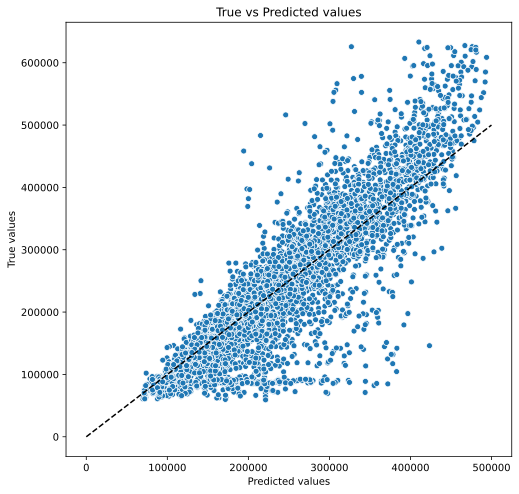

In [52]:
evaluate_preds(y, y_pred)

In [53]:
rfc_ls.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=16, max_features=9, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=450, n_jobs=None, oob_score=False,
                      random_state=100, verbose=0, warm_start=False)